In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
# Python
from pathlib import Path
import os
import warnings
import math
import datetime
import time
warnings.filterwarnings('ignore')

# MISC
from tqdm import tqdm
import pprint
import numpy as np
import matplotlib.pyplot as plt
from dotted_dict import DottedDict
import pickle

# TORCH
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T

# LOCAL
import utils
from csprites.datasets import ClassificationDataset

In [4]:
# TORCH SETTINGS
torch.backends.cudnn.benchmark = True
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
#
device = torch.device("cpu")

# Dataset

In [5]:
# DATASET
p_data = "/mnt/data/csprites/single_csprites_32x32_n2_c2_a1_p1_s1_bg_1_constant_color_4"
p_ds_config = Path(p_data) / "config.pkl"

with open(p_ds_config, "rb") as file:
    ds_config = pickle.load(file)
#
pprint.pprint(ds_config)

{'bg_style': 'constant_color',
 'class_maps': {'angle': {0: 0.0},
                'color': {0: [0, 186, 0], 1: [204, 204, 204]},
                'position': {0: 15},
                'scale': {'moon': [7, 9, 11], 'rectangle': [7, 9, 11]},
                'shape': {0: 'rectangle', 1: 'moon'}},
 'classes': ['shape', 'scale', 'color', 'angle', 'py', 'px'],
 'color_cmap': 'nipy_spectral',
 'date': '15/10/2021 16:30:54',
 'img_size': 32,
 'max_mask_fill_rate': 0.9,
 'max_mask_size': 29,
 'means': [0.035888671875, 0.068603515625, 0.035888671875],
 'memory_usage': '0.000 GB',
 'min_mask_fill_rate': 0.1,
 'n_bg': 1,
 'n_classes': {'angle': 1,
               'color': 2,
               'px': 1,
               'py': 1,
               'scale': 1,
               'shape': 2},
 'n_masks': 4,
 'n_samples': 4,
 'n_states': 4,
 'n_train': 4,
 'n_unique': 4,
 'n_valid': 0,
 'name': 'single_csprites_32x32_n2_c2_a1_p1_s1_bg_1_constant_color_4',
 'p_X_train': 'X_train.npy',
 'p_X_valid': 'X_valid.npy',
 'p_Y

In [6]:
# no noamalization
train_transform = T.Compose([
    T.ToTensor(),
])


ds_train = ClassificationDataset(
    p_data = p_data,
    transform=train_transform,
    target_transform=None,
    split="train"
)
dl_train = DataLoader(
    ds_train,
    batch_size=len(ds_train),
    shuffle=True,
    num_workers=4,

    pin_memory=False,
    drop_last=False
)

In [7]:
# get whole dataset into single tensor
X_ori,Y = next(iter(dl_train))
#
print(X_ori.min(), X_ori.max())

tensor(0.) tensor(0.8000)


tensor(0.) tensor(0.8000)


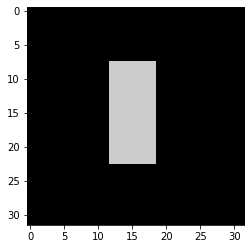

tensor(0.) tensor(0.8000)


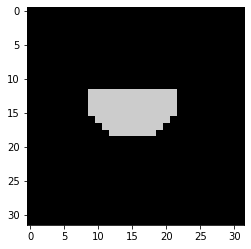

tensor(0.) tensor(0.7294)


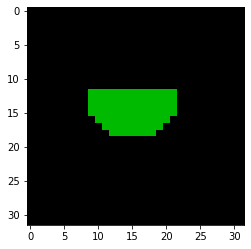

tensor(0.) tensor(0.7294)


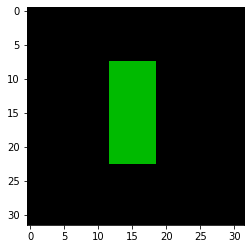

In [8]:
# inverse normalize transform for display
for xi in X_ori:
    print(xi.min(), xi.max())
    plt.imshow(xi.permute(1,2,0))
    plt.show()

# Model

In [17]:
encoder = torch.nn.Sequential(
    nn.Conv2d(3, 1, kernel_size=(11, 11), stride=5, padding=0),
    nn.ReLU(inplace=True),
    torch.nn.Flatten(),
    torch.nn.Linear(25, 2),
    nn.ReLU(inplace=True)
)
decoder = torch.nn.Sequential(
    torch.nn.Linear(2, 512),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(512, 32*32*3),
    torch.nn.Sigmoid(), # need function to map in [0, 1]
)
# test pipeline
with torch.no_grad():
    z = encoder(torch.rand(1,3,32,32))
    d = decoder(z)

In [18]:
loss_fn = torch.nn.MSELoss()
#
lr= 0.001
#
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
#
n_epochs = 1000

0 0.24141307175159454


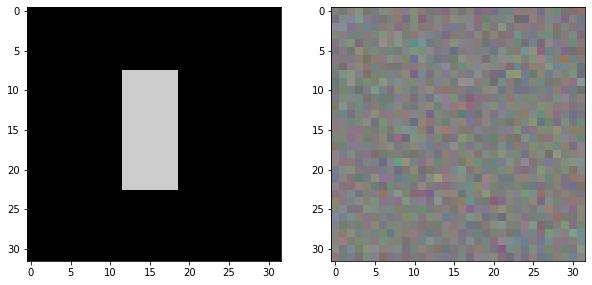

100 0.017533086240291595
200 0.016863731667399406


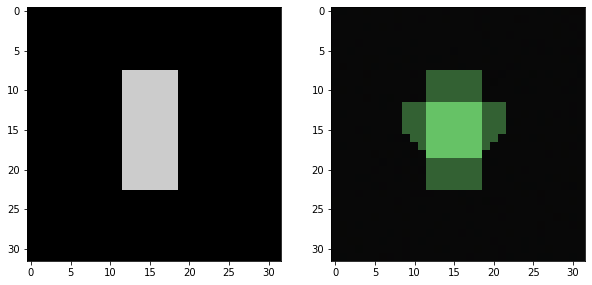

300 0.016666674986481667
400 0.016562914475798607


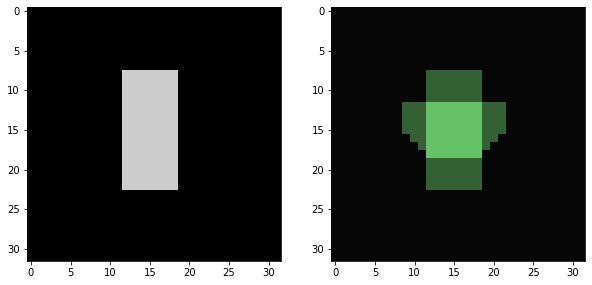

500 0.016490282490849495
600 0.0164434015750885


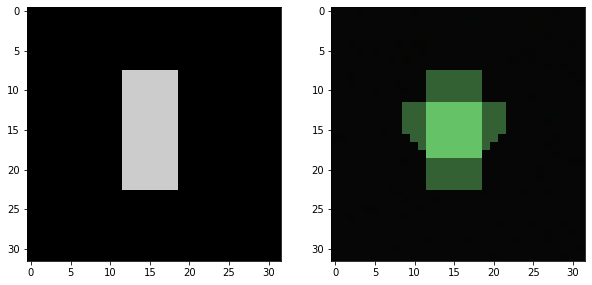

700 0.016404056921601295
800 0.003315904876217246


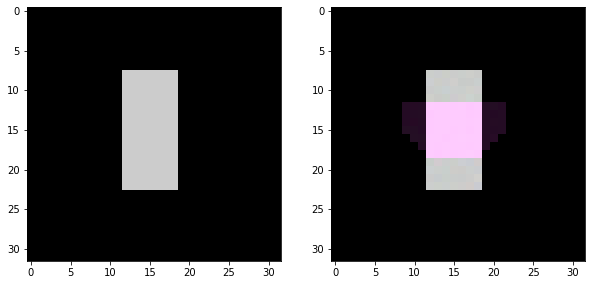

900 0.00017312855925410986


In [19]:
for epoch_idx in range(n_epochs):
    optim.zero_grad()
    z = encoder(X_ori)
    X_rec = decoder(z)
    X_rec = X_rec.reshape(-1, 3, 32, 32)
    #
    loss = loss_fn(X_rec, X_ori)
    loss.backward()
    optim.step()
    #
    if epoch_idx % 100 == 0:
        print(epoch_idx, loss.item())
    if epoch_idx % 200 == 0:
        with torch.no_grad():
            #
            x_rec = X_rec.permute(0,2,3,1).detach()[0]
            x_ori = X_ori.permute(0,2,3,1).detach()[0]
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(x_ori)
        axes[1].imshow(x_rec)
        plt.show()

In [20]:
with torch.no_grad():
    Z = encoder(X_ori)
    X_rec = decoder(z)
    X_rec = X_rec.reshape(-1, 3, 32, 32)
#
#
X_ori = X_ori.permute(0,2,3,1)
X_rec = X_rec.permute(0,2,3,1)

In [21]:
print(X_ori.min(), X_ori.max())
print(X_rec.min(), X_rec.max())

tensor(0.) tensor(0.8000)
tensor(2.5249e-07) tensor(0.8983)


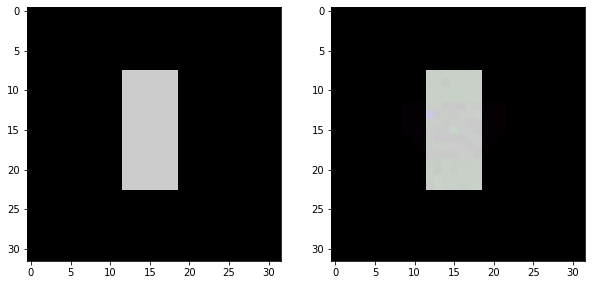

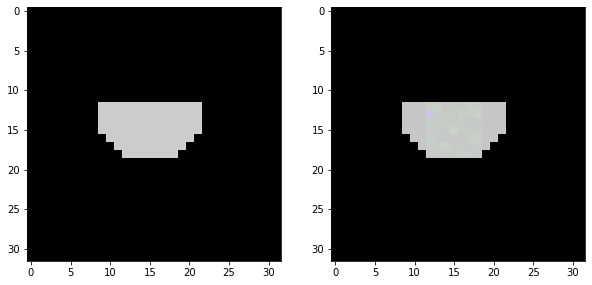

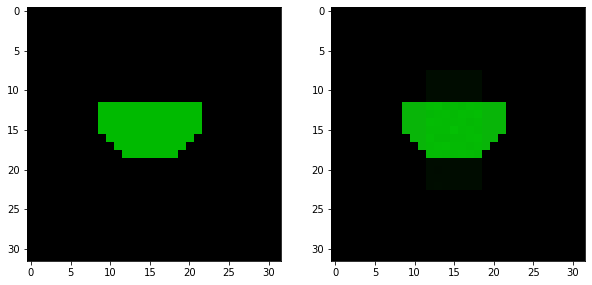

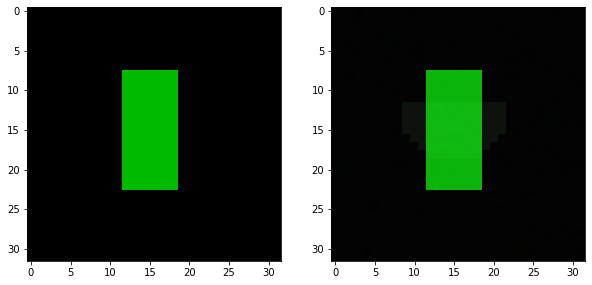

In [22]:
for idx in range(len(X_ori)):
    x_ori = X_ori[idx]
    x_rec = X_rec[idx]
    #
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(x_ori)
    axes[1].imshow(x_rec)
    plt.show()

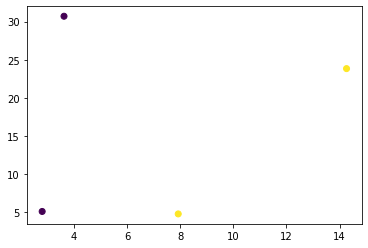

In [23]:
# shape
plt.scatter(Z[:,0], Z[:,1], c=list(Y[:,0].numpy()))
plt.show()

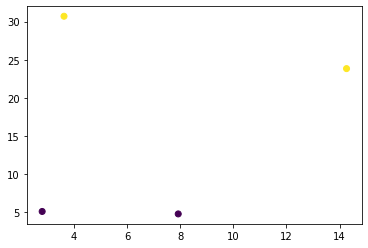

In [24]:
# color
plt.scatter(Z[:,0], Z[:,1], c=list(Y[:,2].numpy()))
plt.show()

In [25]:
convs = list(encoder.parameters())[0].data

In [26]:
convs.shape

torch.Size([1, 3, 11, 11])

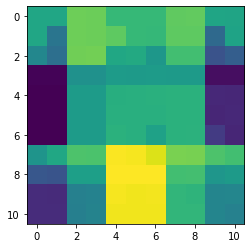

tensor([[0.1565, 0.1565, 0.1847, 0.1841, 0.1682, 0.1681, 0.1682, 0.1813, 0.1816,
         0.1557, 0.1551],
        [0.1565, 0.1257, 0.1848, 0.1840, 0.1805, 0.1682, 0.1677, 0.1809, 0.1809,
         0.1188, 0.1546],
        [0.1368, 0.1224, 0.1856, 0.1857, 0.1570, 0.1590, 0.1472, 0.1727, 0.1723,
         0.1060, 0.1122],
        [0.0686, 0.0686, 0.1435, 0.1436, 0.1497, 0.1497, 0.1498, 0.1495, 0.1493,
         0.0730, 0.0729],
        [0.0677, 0.0677, 0.1501, 0.1503, 0.1620, 0.1625, 0.1627, 0.1636, 0.1636,
         0.0845, 0.0839],
        [0.0677, 0.0677, 0.1503, 0.1503, 0.1627, 0.1622, 0.1622, 0.1635, 0.1635,
         0.0838, 0.0845],
        [0.0677, 0.0673, 0.1503, 0.1501, 0.1636, 0.1626, 0.1536, 0.1639, 0.1641,
         0.0937, 0.0836],
        [0.1456, 0.1570, 0.1760, 0.1756, 0.2170, 0.2158, 0.2100, 0.1875, 0.1872,
         0.1759, 0.1723],
        [0.1084, 0.1065, 0.1524, 0.1525, 0.2175, 0.2180, 0.2180, 0.1726, 0.1730,
         0.1466, 0.1497],
        [0.0863, 0.0861, 0.1327, 0.13

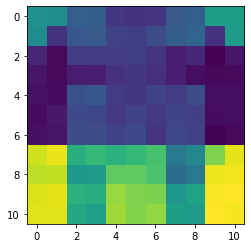

tensor([[ 0.1332,  0.1242,  0.0279,  0.0248, -0.0456, -0.0502, -0.0479,  0.0169,
          0.0276,  0.1604,  0.1606],
        [ 0.1230, -0.0497,  0.0139,  0.0171, -0.0277, -0.0302, -0.0055,  0.0255,
          0.0380, -0.0510,  0.1537],
        [-0.0708, -0.1122, -0.0363, -0.0340, -0.0335, -0.0312, -0.0496, -0.0816,
         -0.0668, -0.1254, -0.0946],
        [-0.0948, -0.1123, -0.0855, -0.0836, -0.0521, -0.0452, -0.0549, -0.0824,
         -0.1064, -0.1148, -0.1125],
        [-0.1022, -0.1084,  0.0036,  0.0129, -0.0371, -0.0452, -0.0226, -0.0339,
         -0.0053, -0.1067, -0.1060],
        [-0.1113, -0.0902, -0.0137, -0.0154, -0.0395, -0.0202, -0.0398, -0.0213,
         -0.0285, -0.1092, -0.1059],
        [-0.1045, -0.0961, -0.0091, -0.0059, -0.0231, -0.0135, -0.0473, -0.0167,
         -0.0262, -0.1207, -0.1115],
        [ 0.3478,  0.3695,  0.1960,  0.2166,  0.2000,  0.2132,  0.2360,  0.0811,
          0.1105,  0.2862,  0.3640],
        [ 0.3330,  0.3382,  0.1456,  0.1573,  0.2595,  0

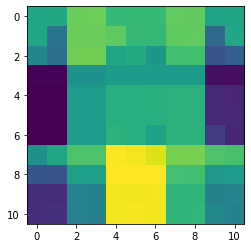

tensor([[0.1565, 0.1570, 0.1841, 0.1848, 0.1677, 0.1679, 0.1681, 0.1816, 0.1815,
         0.1548, 0.1552],
        [0.1565, 0.1255, 0.1845, 0.1838, 0.1804, 0.1675, 0.1677, 0.1810, 0.1816,
         0.1195, 0.1579],
        [0.1368, 0.1228, 0.1854, 0.1856, 0.1562, 0.1593, 0.1473, 0.1726, 0.1725,
         0.1060, 0.1124],
        [0.0686, 0.0686, 0.1439, 0.1439, 0.1494, 0.1495, 0.1495, 0.1495, 0.1492,
         0.0730, 0.0730],
        [0.0677, 0.0677, 0.1502, 0.1502, 0.1626, 0.1625, 0.1627, 0.1640, 0.1636,
         0.0844, 0.0837],
        [0.0677, 0.0677, 0.1502, 0.1502, 0.1623, 0.1626, 0.1626, 0.1641, 0.1636,
         0.0839, 0.0842],
        [0.0677, 0.0673, 0.1503, 0.1503, 0.1644, 0.1624, 0.1538, 0.1640, 0.1641,
         0.0936, 0.0837],
        [0.1428, 0.1566, 0.1762, 0.1760, 0.2169, 0.2156, 0.2100, 0.1873, 0.1871,
         0.1757, 0.1742],
        [0.1079, 0.1070, 0.1524, 0.1523, 0.2176, 0.2177, 0.2180, 0.1728, 0.1722,
         0.1478, 0.1502],
        [0.0868, 0.0867, 0.1339, 0.13

In [27]:
for conv in convs[0]:
    plt.imshow(conv)
    plt.show()
    print(conv)